In [1]:
import os
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
import mlflow

import wandb

import time
from datetime import datetime
from pytz import timezone

from utils import seed_everything, plot_explain, data_load, mlflow_image
from data import categorical_feature,assess_count,\
    feature_engineering,custom_train_test_split,percentile,time_feature_engineering

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.callbacks import Callback

from mlflow_util import MLCallback,connect_server


### Parameter Class 설정

In [84]:
class CFG:
    SEED = 42
    N_EPOCHS = 10
    BATCH_SZ = 1024
    PATIENCE = 3
    VIRTUAL_BS = 128 
    # Ghost batch normalization의 배치사이즈, Batch size의 약수여야함
    LR = 0.01
    ND = 8  # prediction layer dim 크기
    NA = 8  # attention layer dim 크기, ND와 같이 하는게 좋다고 함
    N_STEPS = 3 # step 수 (usually between 3 and 10)
    GAMMA = 1.3 # mask 재사용 정도를 조정하는 파라미터, 1에 가까울 수록 재사용 안함
    #Values range from 1.0 to 2.0.
    N_INDEPENDENT = 2 # Feature transformer의 독립적으로 사용하는 GLU개수 (1~5)
    LAMBDA = 0 # loss에 mask의 sparse 정도를 전달해주는 파라미터
    # 클수록 feature selection 단계에서 sparse하게 선택한다고 함
    N_SHARED = 2 # Feature transformer의 공유하며 사용하는 GLU개수 (1~5)
    MOMENTUM = 0.1
    CLIP = 1.0
    CAT_EMB_DIM = 4
    MASK_TYPE = 'sparsemax' #(default='sparsemax') Either "sparsemax" or "entmax" : this is the masking function to use for selecting features
    DATA_PATH = '../../data/'

### Feature_engineering, train_test_split

In [23]:
seed_everything(CFG.SEED)

cat_features = ['userID','assessmentItemID','testId','KnowledgeTag','assess_count']
# data load
df = data_load(CFG.DATA_PATH)

# time feature engineering
df = assess_count(df)
df = time_feature_engineering(df)

# feature engineering
df = feature_engineering(df)
df.fillna(0,inplace = True)
df = categorical_feature(df,cat_features)

### Data -> train,valid,test

In [24]:
# train test split
train = df[df['answerCode']>-1]
test = df[df['answerCode']==-1]
train,valid = custom_train_test_split(train)

### 사용 Feature 설정

In [25]:
# 유저, 문제, 시험지, 태그 추가
FEATS = ['userID','assessmentItemID','testId','KnowledgeTag','Time','Timediff','Timepassed','Time_answer_rate','assess_count',
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','answerCode']
train_set = train[FEATS]
valid_set = valid[FEATS]
cat_idxs = [train_set.columns.get_loc(col) for col in cat_features]
cat_dims = [df[col].nunique() for col in cat_features]

### TabNet 불러오기

In [85]:
model = TabNetClassifier(
    n_d = CFG.ND,
    n_a = CFG.NA,
    n_steps = CFG.N_STEPS,
    gamma = CFG.GAMMA, 
    n_independent = CFG.N_INDEPENDENT,
    n_shared = CFG.N_SHARED,
    cat_emb_dim=CFG.CAT_EMB_DIM,
    optimizer_params=dict(lr=CFG.LR),
    momentum=CFG.MOMENTUM,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    verbose=1,
    #scheduler_params=dict(milestones=[20, 50, 80], gamma=0.5), 
    #scheduler_fn=torch.optim.lr_scheduler.MultiStepLR,
    mask_type = CFG.MASK_TYPE,
    lambda_sparse = CFG.LAMBDA,
    clip_value = CFG.CLIP
)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


### MLflow 불러오기

In [ ]:
now = datetime.now(tz = timezone('Asia/Seoul'))
date_str = now.strftime('%m-%d-%H:%M:%S')
remote_server_uri,experiment_id = connect_server()
ml_callback = MLCallback
run_name="tabent"+date_str
desc="tabnet emergency"
mlflow.end_run()

### 모델 학습

In [156]:
run_name="tabent mlflow test"
desc="tabnet emergency"
mlflow.end_run()
model.fit(
    X_train = train_set.drop(columns = 'answerCode').values,
    y_train = train_set['answerCode'].values,
    eval_set = [(train_set.drop(columns = 'answerCode').values,train_set['answerCode'].values),(valid_set.drop(columns = 'answerCode').values,valid_set['answerCode'].values)],
    eval_name = ['train','valid'],
    eval_metric = ['auc','accuracy'],
    max_epochs = CFG.N_EPOCHS, 
    patience = CFG.PATIENCE,
    batch_size = CFG.BATCH_SZ, 
    virtual_batch_size = CFG.VIRTUAL_BS,
    num_workers = 0,
    weights = 1,
    drop_last = False,
    callbacks=[ml_callback(remote_server_uri, experiment_id, run_name, desc, model.get_params())]
)

KeyboardInterrupt: 

### 모델 저장 및 불러오기

In [38]:
# save tabnet model
saving_path_name = "./saved/tabnet_" + date_str
model.save_model(saving_path_name)

Successfully saved model at ./saved/tabnet_12-04-19:32:28.zip


'./saved/tabnet_12-04-19:32:28.zip'

In [29]:
# define new model with basic parameters and load state dict weights
saving_path_name = "./saved/tabnet_12-04 19:19:04"
model = TabNetClassifier()
model.load_model(saving_path_name + '.zip')

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


### Test set Prediction

In [96]:
valid_proba =  model.predict_proba(valid_set[FEATS].drop(columns = 'answerCode').values)
valid_preds =  model.predict(valid_set[FEATS].drop(columns = 'answerCode').values)
valid_auc = roc_auc_score(valid_set['answerCode'],valid_proba[:,1])
valid_acc = accuracy_score(valid_set['answerCode'],valid_preds)

### submission 저장

In [53]:
total_preds = model.predict_proba(test[FEATS].drop(columns = 'answerCode').values)[:,1]
submission = pd.read_csv('../../data/sample_submission.csv')
submission['prediction'] = total_preds
submission.to_csv('./submission/submission'+date_str+'.csv')

### Explain

In [97]:
explain, masks = model.explain(valid_set.drop(columns = 'answerCode').values)
# np.savez('./explain/'+date_str,explain = explain,mask0 = masks[0],mask1=masks[1],mask2 = masks[2])

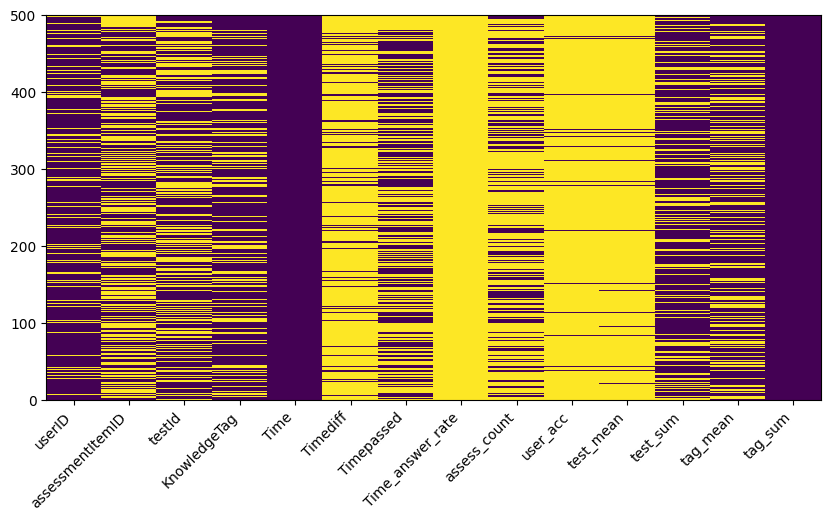

In [124]:
plot_explain(explain,FEATS) # valid_set

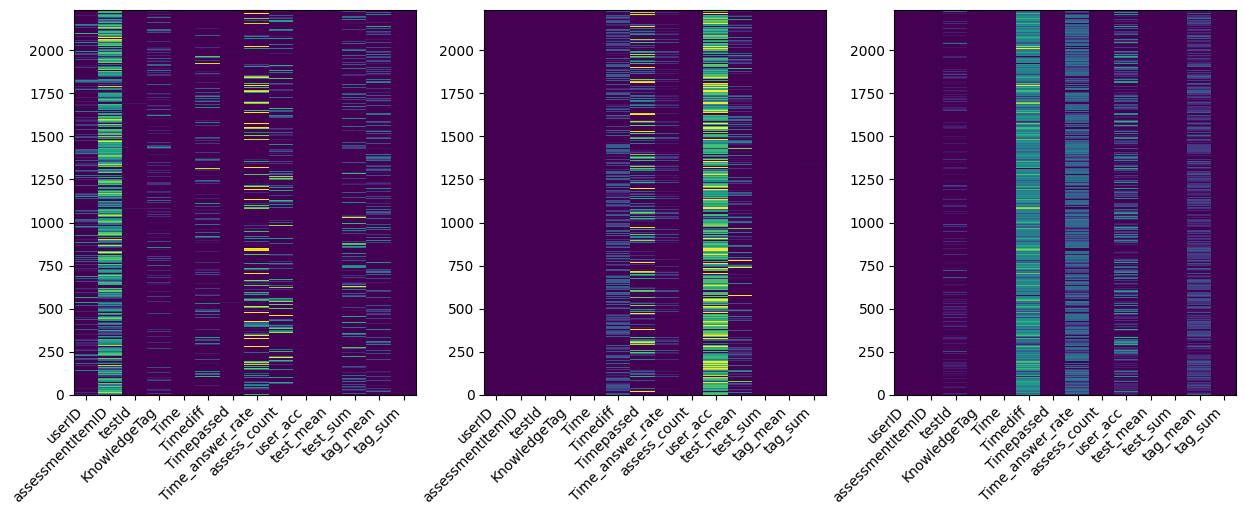

In [37]:
plot_explain(masks,FEATS) # valid_set